In [22]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from hydramuscle.model.smc import SMC
from hydramuscle.model.fluo_encoder import FluoEncoder
from hydramuscle.utils import utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
model = SMC(T=400, 
            dt=0.0002, 
            k_ipr=0.05, 
            s0=100, 
            d=20e-4, 
            k_deg=0.05)

In [16]:
# Single fast spike
sol = model.run(stims_fast = [0], 
                stims_slow = [-100],
                T=2,
                dt=0.0002)
c_fast_1 = sol[:, 0]
v_fast_1 = sol[:, 4]
m_fast_1 = sol[:, 5]
h_fast_1 = sol[:, 6]
n_fast_1 = sol[:, 7]

100%|██████████| 10000/10000 [00:00<00:00, 21468.12it/s]


In [4]:
# Multiple fast spikes
sol = model.run(stims_fast=[0.0, 9.25, 14.5, 18.25, 21.5, 24.5, 28.0, 31.5, 35.25, 40.5],
                stims_slow=[-100])
c_fast_mul = sol[:, 0]
v_fast_mul = sol[:, 4]
fluo_encoder = FluoEncoder(c_fast_mul, T=model.T, dt=model.dt)
fluo_mul = utils.normalize(fluo_encoder.step())

100%|██████████| 2000000/2000000 [01:28<00:00, 22581.49it/s]


In [50]:
# Slow pathway
sol = model.run(stims_fast=[-100],
                stims_slow=[10],
                T=100,
                dt=0.0002)
c_slow = sol[:, 0]
s_slow = sol[:, 1]
r_slow = sol[:, 2]
ip_slow = sol[:, 3]
v_slow = sol[:, 4]
m_slow = sol[:, 5]
h_slow = sol[:, 6]

100%|██████████| 500000/500000 [00:23<00:00, 21597.60it/s]


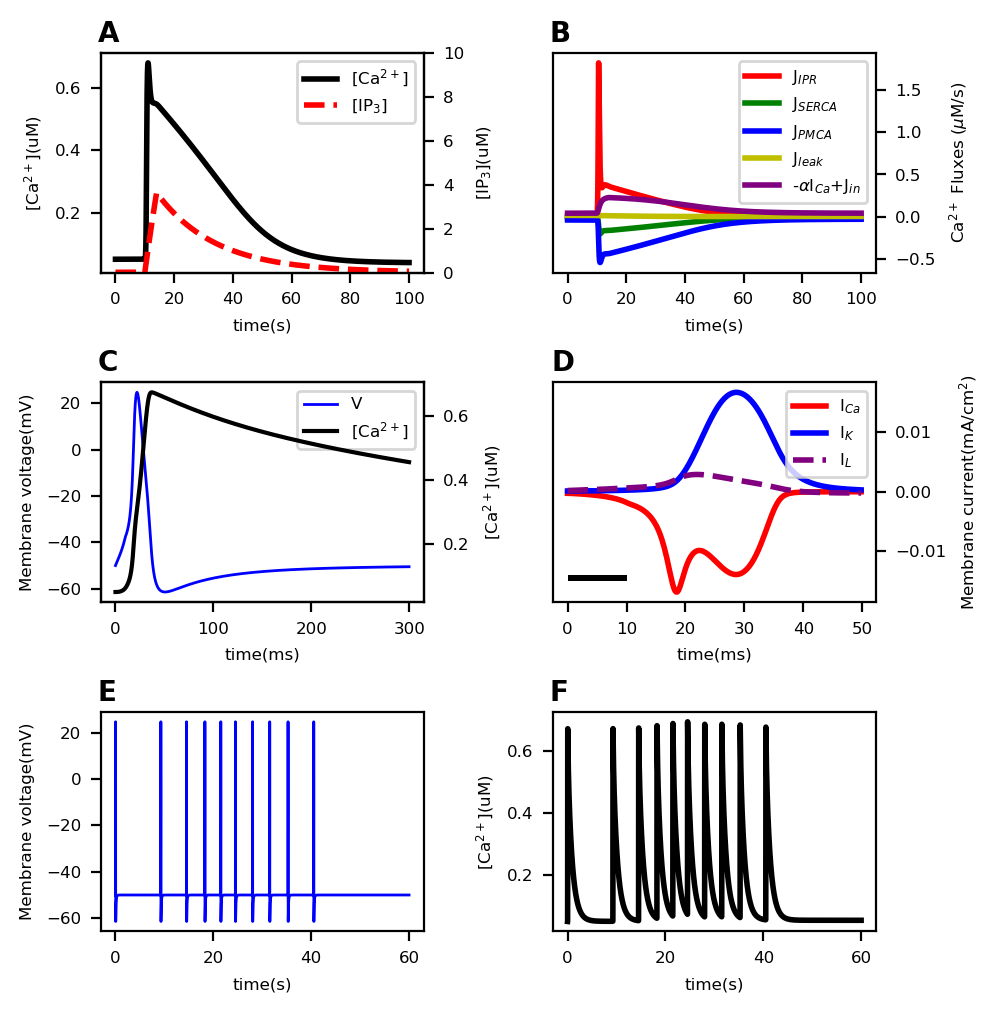

In [145]:
FONTSIZE = 6
TEXTSIZE = 10
LINEWIDTH = 2

fig = plt.figure(figsize=(5,8), dpi=200)

# Add axes
gs = gridspec.GridSpec(4, 1, height_ratios=[2, 2, 2, 2])
gs.update(hspace=0.5)
gs0 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[0], hspace=0.5, wspace=0.4)
gs1 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[1], hspace=0.3, wspace=0.4)
gs2 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[2], hspace=0.3, wspace=0.4)

axs0 = [plt.subplot(gs0[0, 0]), plt.subplot(gs0[0, 1])]
axs1 = [plt.subplot(gs1[0, 0]), plt.subplot(gs1[0, 1])]
axs2 = [plt.subplot(gs2[0, 0]), plt.subplot(gs2[0, 1])]

axs_all = [axs0, axs1, axs2]
gs_all = [gs0, gs1, gs2]

# Plot slow pathway
timex = np.arange(0, 100, 0.0002)

## Plot [Ca2+] and IP3
ax = axs0[0]
lns1 = ax.plot(timex, c_slow, linewidth=LINEWIDTH, color="k", label='[Ca$^{2+}$]')
ax.tick_params(axis='x', labelsize=FONTSIZE, labelcolor='k')
ax.tick_params(axis='y', labelsize=FONTSIZE, labelcolor='k')
ax.set_xlabel("time(s)", fontsize=FONTSIZE)
ax.set_ylabel(r"[Ca$^{2+}$](uM)", fontsize=FONTSIZE)
ax.text(-0.01, 1.05, 'A', size=TEXTSIZE, weight="bold", transform=ax.transAxes)

ax_ = ax.twinx()
lns2 = ax_.plot(timex, ip_slow,
         linewidth=LINEWIDTH, color="r", linestyle="--", label='[IP$_3$]')
ax_.tick_params(axis='y', labelsize=FONTSIZE, labelcolor='k')
ax_.set_ylim(0, 10)
ax_.set_ylabel(r"[IP$_3$](uM)", fontsize=FONTSIZE, color='k')

lns = lns1 + lns2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, fontsize=FONTSIZE, loc="upper right")

## Plot calcium flows
ax = axs0[1]
ax.plot(timex, model.i_ipr(c_slow, s_slow, ip_slow, r_slow), linewidth=LINEWIDTH, color="r", label=r"J$_{IPR}$")
ax.plot(timex, -model.i_serca(c_slow), linewidth=LINEWIDTH, color="g", label=r"J$_{SERCA}$")
ax.plot(timex, -model.i_pmca(c_slow), linewidth=LINEWIDTH, color="b", label=r"J$_{PMCA}$")
ax.plot(timex, model.i_leak(c_slow, s_slow), linewidth=LINEWIDTH, color="y", label=r"J$_{leak}$")
ax.plot(timex, -model.alpha * model.i_ca(v_slow, m_slow, h_slow) + model.i_in(ip_slow),
         linewidth=LINEWIDTH, color="purple", label=r"-$\alpha$I$_{Ca}$+J$_{in}$")

ax.tick_params(labelsize=FONTSIZE)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.set_xlabel("time(s)", fontsize=FONTSIZE)
ax.set_ylabel(r"Ca$^{2+}$ Fluxes ($\mu$M/s)", fontsize=FONTSIZE)
ax.text(-0.01, 1.05, 'B', size=TEXTSIZE, weight="bold", transform=ax.transAxes)
ax.legend(fontsize=FONTSIZE, loc='upper right')


#　Plot single fast spike
timex = np.arange(0, 0.3, 0.0002)

## Plot V and [Ca2+]
ax_ = axs1[0]
lns1 = ax_.plot(timex * 1000, v_fast_1[:1500], linewidth=LINEWIDTH-1, color="b", label='V')
ax_.tick_params(labelsize=FONTSIZE)
ax_.set_xlabel("time(ms)", fontsize=FONTSIZE)
ax_.set_ylabel("Membrane voltage(mV)", fontsize=FONTSIZE)

ax = ax_.twinx()
lns2 = ax.plot(timex * 1000, c_fast_1[:1500], linewidth=LINEWIDTH-0.5, color="k", label='[Ca$^{2+}$]')
ax.tick_params(labelsize=FONTSIZE)
ax.set_xlabel("time(ms)", fontsize=FONTSIZE)
ax.set_ylabel(r"[Ca$^{2+}$](uM)", fontsize=FONTSIZE)
ax.text(-0.01, 1.05, 'C', size=TEXTSIZE, weight="bold", transform=ax_.transAxes)

lns = lns1 + lns2
labs = [l.get_label() for l in lns]
ax_.legend(lns, labs, fontsize=FONTSIZE, loc="upper right")

## Plot currents
timex = np.arange(0, 0.05, 0.0002)
ax = axs1[1]
ax.plot(timex * 1000, model.i_ca(v_fast_1, m_fast_1, h_fast_1)[:250],
         linewidth=LINEWIDTH, color="r", label=r"I$_{Ca}$")
ax.plot(timex * 1000, model.i_k(v_fast_1, n_fast_1)[:250],
         linewidth=LINEWIDTH, color="b", label=r"I$_{K}$")
ax.plot(timex * 1000, model.i_bk(v_fast_1)[:250],
         linewidth=LINEWIDTH, color="purple", linestyle="--", label=r"I$_{L}$")
ax.legend(fontsize=FONTSIZE, loc='upper right')
ax.tick_params(labelsize=FONTSIZE)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.set_xlabel("time(ms)", fontsize=FONTSIZE)
ax.set_ylabel(r"Membrane current(mA/cm$^2$)", fontsize=FONTSIZE)
ax.text(-0.005, 1.05, 'D', size=TEXTSIZE, weight="bold", transform=ax.transAxes)
ax.bar(0, 0.001, width=10, bottom=-0.015, align='edge', color='k')

# Plot multiple spikes
ax = axs2[0]
timex = np.arange(0, 60, 0.0002)

ax.plot(timex, v_fast_mul[:300000], linewidth=LINEWIDTH-1, color="b")
ax.tick_params(labelsize=FONTSIZE)
ax.set_xlabel("time(s)", fontsize=FONTSIZE)
ax.set_ylabel("Membrane voltage(mV)", fontsize=FONTSIZE)
ax.text(-0.01, 1.05, 'E', size=TEXTSIZE, weight="bold", transform=ax.transAxes)

ax_ = axs2[1]
ax_.plot(timex, c_fast_mul[:300000], linewidth=LINEWIDTH, color="k")
ax_.tick_params(labelsize=FONTSIZE)
ax_.set_xlabel("time(s)", fontsize=FONTSIZE)
ax_.set_ylabel(r"[Ca$^{2+}$](uM)", fontsize=FONTSIZE)
ax_.text(-0.01, 1.05, 'F', size=TEXTSIZE, weight="bold", transform=ax_.transAxes)

plt.savefig("../results/figures/single-dynamics.png", bbox_inches='tight')
plt.show()